### **Task 1**
#### Scraping Edmounds.com to fetch about 5,000 posts with the following data: date, user-id, and message.

In [135]:
import csv
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from requests.exceptions import RequestException
import time

# Function to extract post data from a URL
def extract_posts_from_url(url, target_posts=5000):
    try:
        # Create a session object to persist settings across requests
        session = requests.Session()

        # Configure retry logic for handling failed requests
        retry = Retry(
            total=5,  # Total number of retry attempts
            backoff_factor=0.5,  # Time to wait between retries (grows exponentially: 0.5, 1, 2, etc.)
            status_forcelist=[403, 500, 502, 503, 504],  # Retry only on these HTTP status codes
        )
        adapter = HTTPAdapter(max_retries=retry)
        session.mount('http://', adapter)
        session.mount('https://', adapter)

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
            'Accept-Language': 'en-US,en;q=0.9',
            'Accept-Encoding': 'gzip, deflate, br',
            'Connection': 'keep-alive',
        }

        # Make the request to the URL
        response = session.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Parse the page
        soup = BeautifulSoup(response.text, 'html.parser')

        # Initialize list to store post data
        posts = []

        # Set up a counter for the posts
        post_count = 0

        # Loop through the pages until we've collected enough posts
        while post_count < target_posts:
            # Find all posts on the current page (adjust this selector based on the forum's structure)
            post_elements = soup.find_all('div', class_='Comment') 

            # Process each post
            for post in post_elements:
                if post_count >= target_posts:
                    break  # Stop once target reached

                # Extract the required data using the tags and classes based on the forum's structure
                date = post.find('span', class_='MItem DateCreated').find('time')['title'].split(' ')[:3] # 'time' refers to the <time> tag and 'title' refers to the attribute within the time tag
                date = ' '.join(date) # to piece the date components together
                user_id = post.find('span', class_='Author').find('a')['data-userid']
                message = post.find('div', class_='Message userContent').text.strip()

                # Append the extracted data to the posts list
                posts.append([date, user_id, message])

                post_count += 1  # Increase the post counter

            # Check for pagination and fetch the next page if available
            next_page = soup.find('a', {'class': 'Next'}) 
            if next_page:
                next_page_url = next_page['href']
                response = session.get(next_page_url, headers=headers, timeout=10)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, 'html.parser')
            else:
                break  # Exit the loop if there's no next page

            time.sleep(1)  # Add a short delay to avoid overwhelming the server

        return posts

    except RequestException as e:
        print(f"Error scraping {url}: {e}")
        return []

# Function to save scraped data into a CSV file
def save_posts_to_csv(posts, output_csv):
    with open(output_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['date', 'user-id', 'message'])  # Write the header row
        writer.writerows(posts)  # Write the post data rows

# Main entry point
if __name__ == "__main__":
    url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'  # replace dynamically
    target_posts = 5000  # Specify the number of posts to scrape
    output_csv = 'scraped_posts.csv'

    # Extract posts
    posts = extract_posts_from_url(url, target_posts)

    # Save the posts to a CSV file
    save_posts_to_csv(posts, output_csv)

    print(f"Successfully scraped {len(posts)} posts.")

Successfully scraped 5000 posts.


### **Task 2**
#### Identify top 10 brands by frequency

Load necessary libraries

In [136]:
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

! pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import seaborn as sns
from sklearn.manifold import MDS
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from tabulate import tabulate
from nltk.stem import WordNetLemmatizer

#### Count the unique words in the messages and their associated frequencies
Objective: identify potentially missed out models/brands in the provided dataset

In [137]:
# Download the NLTK stopwords [download method]
nltk.download('stopwords')

# Load dataset
scraped_posts = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY669/Assignments/scraped_posts.csv')

# Extract the 'message' column
scraped_posts['message'] = scraped_posts['message'].astype(str) # Cast the messages column to string type
messages = scraped_posts['message'] 

# Clean the text: Convert to lowercase, remove punctuation, and split into words
processed_messages = ' '.join(messages).lower() # combines all text strings across rows into a single string, separated by spaces
processed_messages = re.sub(r'[^\w\s]', '', processed_messages)  # Removes anything that is not a word character (punctuation and special characters) and sub with empty string. works on text already combined from all reviews, does not handle each review individually
words = processed_messages.split()

# Use nltk stopwords
stop_words = set(stopwords.words('english'))

# Remove stopwords and pass to an object called filtered_words
filtered_words = [word for word in words if word not in stop_words]

# Count the frequency of each word
word_counts = Counter(filtered_words)
# Counter is a class from the collections module that creates dictionary like obj where keys are unique words from the list and values are the counts of the words

# Extract top 500 words counted and their frequencies
top_words = word_counts.most_common(500)

# Convert word count into dataframe
word_counts_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Find top unique words
word_counts_df['Word'].unique()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiajue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array(['car', 'cars', 'like', 'bmw', 'tl', 'one', 'would', 'dont', 'get',
       'g35', 'think', 'better', 'drive', 'new', 'im', 'much',
       'performance', '3', 'even', 'people', 'good', 'really', 'know',
       'driving', 'well', 'want', 'also', 'luxury', 'sedan', 'rwd', 'say',
       'still', 'best', 'engine', '330i', 'time', 'way', 'make', 'see',
       'series', 'buy', 'fwd', 'thats', 'great', 'go', 'price', 'many',
       'could', 'awd', 'test', 'g', 'interior', 'power', 'going', 'hp',
       'handling', 'look', 'back', 'manual', 'acura', 'years', 'less',
       'doesnt', 'ive', 'lexus', 'infiniti', 'cant', 'take', 'right',
       'two', 'may', 'tires', 'said', 'feel', 'got', 'never', 'sport',
       'sales', 'point', 'id', 'sure', 'little', 'different', 'need',
       'torque', 'around', 'thing', 'lot', 'didnt', 'class', 'year',
       'road', 'something', 'looking', 'every', 'cts', 'getting', 'maybe',
       'first', 'since', 'audi', 'probably', 'believe', '5', 'a4',
       '

Models corresponding to brands were manually added into the model dataset which will be loaded in the next section. Aside from that, irrelevant entries (car/cars, sedan/sedans, problem/problems) not relating to specific brands/models were also removed.

Additions made to the dataset for the brands and their associated models/ acronyms are as follows:
1. Acura: tl/tls
2. Audi: audis
3. BMW: 325, e90, 325i, 330i, 530i, zhp
3. Cadillac: cadillacs
4. Chrysler: 300, 300s, 300c
5. Infiniti: g35, g35x, infinitis
6. Jaguar: x-type
7. Lexus: CT-Hybrid, GS-F, es, gs, gs hybrid, gx, is300, is350, is500, lc, ls, nx, rc, rx
8. Mercedes: mb
9. Pontiac: pontiacs
10. Subaru: sti, subarus
11. Suzuki: suzukis
12. Volkswagen: volks 


Even with the adjustments, note that the brand-model dataset which is used in the next code chunk does not include the entire range of models to their respective brands, and thus the number of mentions counted for each brand will be inaccurate.

#### Map car models with their corresponding brands
Fuzzywuzzy package is also used to check for potential spelling errors in model and brand names, which will be corrected and replaced with the corresponding brand names.

Objective: To simplify the analysis for the word count in the subsequent step. Ultimately, the focus is on brand, rather than specific models, thus mapping models to brands will be more relevant.

In [138]:
import re
from fuzzywuzzy import fuzz

# Load dataset
brands = pd.read_csv('/Users/jiajue/Documents/McGill/Winter Term/INSY669/Assignments/Car Models Assignment 1 Data.csv')

# Pre-process the brands dataset (lowercase and remove punctuation)
brands['model'] = brands['model'].str.lower().str.replace(r'[^\w\s]', '', regex=True)
brands['brand'] = brands['brand'].str.lower().str.replace(r'[^\w\s]', '', regex=True)  # Keep brands lowercase as well

# Create a dictionary from the 'brands' dataset, converting both model and brand to lowercase for standardization
model_to_brand = dict(zip(brands['model'], brands['brand']))

# Function to replace models and brands with fuzzy matching
def replace_model_brand(message):
    if isinstance(message, str):  # Check if the message is a string
        message = message.lower()  # Convert to lowercase for consistency
        message = re.sub(r'[^\w\s]', '', message)  # Remove punctuation
        
        # First, handle models to brands
        for model, brand in model_to_brand.items():
            # Check if fuzzy match for model is above threshold
            if fuzz.partial_ratio(model, message) > 80:  # threshold for fuzzy matching
                # Replace model with the corresponding brand
                message = re.sub(r'\b' + re.escape(model) + r'\b', brand, message)

        # Now handle potential brand name corrections
        for model, brand in model_to_brand.items():
            # Here we check if the brand is misspelled in the message and replace it
            if fuzz.partial_ratio(brand, message) > 80:  # Adjust threshold as needed
                message = re.sub(r'\b' + re.escape(brand) + r'\b', brand, message)
        
        return message
    else:
        return message

# Apply the function to each message in the dataset
updated_messages = messages.apply(replace_model_brand)

#### Brand mention frequency count

With models and brand names standardised, the number of mentions of each brand can now be counted.

In [139]:
from collections import Counter

# Initialize the Counter to keep track of brand mentions
brand_counter = Counter()

# Iterate through each message in the dataset
for message in updated_messages:
    if isinstance(message, str):  # Check if message is a string
        # Use a set to track brands that are already counted in the current message
        counted_brands = set()
        
        # Iterate through the model_to_brand dictionary and count brand mentions
        for model, brand in model_to_brand.items():
            # Check if the brand is mentioned in the message
            if brand in message and brand not in counted_brands:
                # Increment the count for the brand and add it to the counted set
                brand_counter[brand] += 1
                counted_brands.add(brand)

# Get the top 10 most mentioned brands
top_10_brands = brand_counter.most_common(10)

# Convert to DataFrame for better visualization
top_10_df = pd.DataFrame(top_10_brands, columns=['Brand', 'Frequency'])

# Display the top 10 brands by frequency
print("Top 10 Brands by Frequency:")
print(top_10_df)

Top 10 Brands by Frequency:
      Brand  Frequency
0       bmw       1688
1  infiniti        976
2     acura        683
3     lexus        508
4      audi        456
5      seat        290
6     honda        259
7    nissan        256
8  mercedes        212
9      ford        184


#### Calculate lift ratios

In [146]:
# List of top 10 brands
top_10_brands = [brand for brand, _ in brand_counter.most_common(10)]

# Create a Binary Matrix for Brand Mentions
# Initialize an empty DataFrame with messages as rows and top 10 brands as columns
binary_matrix = pd.DataFrame(0, index=updated_messages.index, columns=top_10_brands)

# No need for vectoriser in this case because the brands to be identified in each post have already been identified 
# Objective here is to manually check the presence of specific brands in each post to build the binary matrix
# Count vectoriser is typically used for general word level analysis where it extracts all unique words or predefined number of features which is redundant in this case

# Populate the binary matrix
for i, message in enumerate(updated_messages):
    if isinstance(message, str):  # Ensure message is a string
        for brand in top_10_brands:
            if brand in message:  # Check if the brand is mentioned
                binary_matrix.loc[i, brand] = 1
# Each row corresponds to a single post and column corresponds to each of the brands

# Calculate the Co-occurrence Matrix
# Multiply the binary matrix with its transpose to get the co-occurrence matrix
co_occurrence_matrix = binary_matrix.T.dot(binary_matrix)

# Calculate Expected Co-occurrence Matrix
# Compute the marginal frequencies (number of messages mentioning each brand)
brand_frequencies = binary_matrix.sum(axis=0).values  # Sum along columns
total_messages = binary_matrix.shape[0]  # Total number of messages
expected_co_occurrence_matrix = np.outer(brand_frequencies, brand_frequencies) / total_messages

# Calculate the Lift Matrix
# Element-wise division of observed co-occurrence by expected co-occurrence
lift_matrix = co_occurrence_matrix.values / expected_co_occurrence_matrix
np.fill_diagonal(lift_matrix, 0)  # Set diagonal values to 0 (self-lift is not meaningful)

# Convert Lift Matrix to DataFrame
lift_df = pd.DataFrame(lift_matrix, index=top_10_brands, columns=top_10_brands)

# Replace infinities or 0 with NaN
lift_df.replace([np.inf, -np.inf, 0], np.nan, inplace=True)

# Format the lift values for better readability
lift_df = lift_df.round(3)

# Display the Lift Matrix
print("Lift for Top 10 Brands:")
print(lift_df)

Lift for Top 10 Brands:
            bmw  infiniti  acura  lexus   audi   seat  honda  nissan  \
bmw         NaN     1.481  1.357  1.668  1.656  1.481  1.189   1.099   
infiniti  1.481       NaN  1.823  1.946  1.696  1.466  1.246   2.301   
acura     1.357     1.823    NaN  2.363  1.862  1.161  2.940   1.916   
lexus     1.668     1.946  2.363    NaN  2.137  1.358  1.292   1.576   
audi      1.656     1.696  1.862  2.137    NaN  2.155  1.185   1.328   
seat      1.481     1.466  1.161  1.358  2.155    NaN  1.065   1.347   
honda     1.189     1.246  2.940  1.292  1.185  1.065    NaN   5.430   
nissan    1.099     2.301  1.916  1.576  1.328  1.347  5.430     NaN   
mercedes  1.425     1.305  1.865  3.064  3.052  2.115  1.457   1.750   
ford      1.304     1.336  1.273  1.712  1.788  1.687  2.413   1.911   

          mercedes   ford  
bmw          1.425  1.304  
infiniti     1.305  1.336  
acura        1.865  1.273  
lexus        3.064  1.712  
audi         3.052  1.788  
seat         2.

#### MDS Map plot

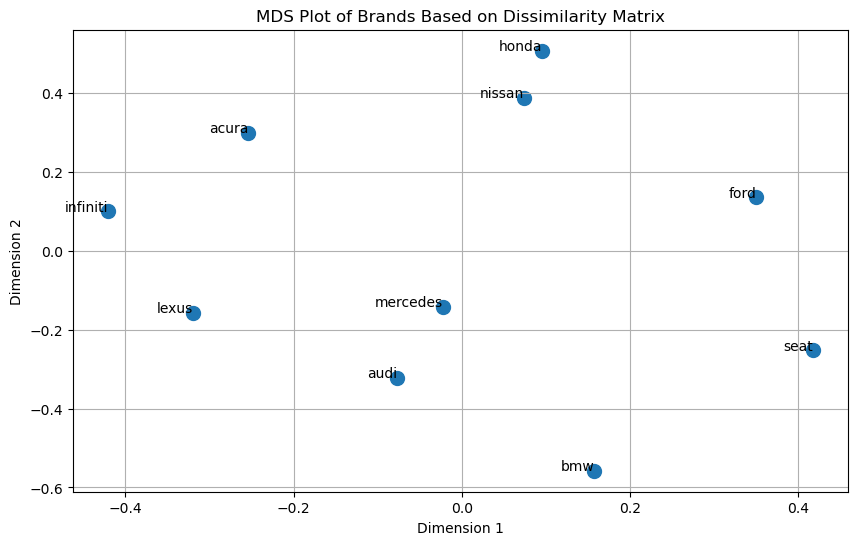

In [141]:
# Replace zero or NaN values in the lift matrix to avoid division by zero
lift_df = lift_df.replace([np.inf, -np.inf, 0], np.nan)

# Calculate the dissimilarity matrix by taking the inverse of the lift values
dissimilarity_matrix = 1 / lift_df

# Replace NaN values (due to division by zero) with a large value indicating maximum dissimilarity
dissimilarity_matrix.fillna(dissimilarity_matrix.max().max() * 2, inplace=True)

# Convert dissimilarity matrix DataFrame to NumPy array
dissimilarity_array = dissimilarity_matrix.values

# Apply MDS to reduce to 2 dimensions
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(dissimilarity_array)

# Create a DataFrame for the MDS results
mds_df = pd.DataFrame(mds_coordinates, columns=['Dimension 1', 'Dimension 2'], index=dissimilarity_matrix.index)

# Plot the MDS result
plt.figure(figsize=(10, 6))
plt.scatter(mds_df['Dimension 1'], mds_df['Dimension 2'], s=100)

# Annotate each point with the wordf
for word, (x, y) in mds_df.iterrows():
    plt.text(x, y, word, fontsize=10, ha='right')

plt.title('MDS Plot of Brands Based on Dissimilarity Matrix')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

### **Task 3**
#### What insights can you offer brand managers from the above analysis? Choose 2 brands to discuss insights.

Based on the data found in the calculation of lift values for the top 10 brands, it was found that there are strong similarities across many car brands. In particular, there are some important insights that can be drawn for 2 luxury brands - Infiniti and Lexus - which have a relatively high lift value of 1.946.

Infiniti is the luxury division of Nissan, which is often associated with performance, sportiness, and dynamic driving experiences. Their vehicles generally emphasise aggressive design, luxury finishes, and a strong performance-oriented brand identity. Thus, their models are typically seen as more driver-focused, especially in terms of handling and road experience, which makes it an attractive option for customers who prioritise a more exciting driving experience over comfort.

Lexus, on the other hand, is the luxury division of Toyota, known for its refinement, comfort, reliability, and luxury. Lexus vehicles tend to prioritize smooth rides, advanced technology, and reliable performance. As a result, it is often considered a symbol of understated luxury—focusing more on comfort than on overtly sporty driving experiences. While there are sporty models such as the Lexus RC F, the majority of its offerings emphasise a smooth, quiet ride with luxury materials and cutting-edge technology that enhances comfort and convenience. Its focus is less on sporty driving dynamics and more on serene luxury experience that balances performance with ease of driving.

Despite overlaps in the features of these brands, there are still methods which they can use to better position themselves and differentiate from one another. For instance, Infiniti can continue to emphasise its performance-driven features while also focusing on how these features elevate the luxury experience—especially for those who enjoy driving. They can also potentially invest in more track-inspired models and engineering innovations that enhance driving dynamics. In terms of its distinct sporty appeal, this should be maintained and more models can be created to attract a younger demographic looking for adventure and thrill—but also incorporate luxury features like upgraded interior materials and technology that appeal to a more refined taste.

As for Lexus, they should focus on their reputation for reliability while enhancing its luxury offerings. This can include providing more personalized luxury experiences and expanding its hybrid models to attract environmentally-conscious buyers who still want the comfort of a premium vehicle. With growing interest in sustainability, Lexus should continue its efforts in the hybrid and electric vehicle space, further promoting its models like the Lexus RX Hybrid and Lexus ES Hybrid. This positioning can attract a new generation of luxury buyers who want both comfort and eco-consciousness.

In all, Infiniti can tap into the performance-oriented luxury market by emphasizing sportiness, aggressive styling, and driver-focused technology. Lexus, on the other hand, can continue to position itself as a brand that delivers refined comfort, reliability, and a premium, quiet ride, appealing to consumers seeking an understated luxury experience. By focusing on these core strengths, both brands can carve out a more distinct and appealing identity that not only appeals to their current audiences but also attracts potential buyers who might be torn between the two.

### **Task 4**
#### Attributes associated with the top 5 most frequently mentioned car brands

A list of attributes have been generated to map to possible terms that were discussed in the forums to facilitate the investigation of association between attributes and the respective car brands.

In [142]:
import string

attribute_dict = {
    "performance": [
        "pick-up", "acceleration", "speed", "horsepower", "hp", "power", "torque", "performance", "engine", 
        "rpm", "stability", "handling", "responsiveness", "drive", "gearbox", "acceleration", "fast", "handling", 
        "transmission", "0-60", "mpg", "fuel", "fuel efficiency", "top speed", "turbo", "awd", "rwd", "fwd", "manual", "automatic", "v6", "v8", "turbocharged", "turbo"
    ],
    "luxury": [
        "luxury", "elegance", "premium", "high-end", "exclusive", "classy", "deluxe", "executive", "opulence",
        "prestige", "grand", "plush", "lavish", "luxurious", "sophisticated"
    ],
    "comfort": [
        "comfort", "smooth", "cushion", "spacious", "relax", "cozy", "roomy", "seating",
        "pillowy", "airy", "spaciousness", "comfortability", "quietness", "quiet", "ride", 
        "suspension", "soft", "noise", "space", "cabin", "climate control",  "sound system", 
        "heated", "sunroof", "cruise control", "experience", "noise isolation", "heating", "aircon", "ac"
    ],
    "reliability": [
        "reliable", "durable", "sturdy", "dependable", "long-lasting", "trustworthy", "robust", "solid", 
        "tough", "dependability", "endurance", "resilience", "safety", "reliability", "durability", "maintenance", 
        "warranty", "service", "dealer", "breakdown", "issues", "repair", "lifetime", "parts", "recall", "battery"
    ],
    "design": [
        "stylish", "sleek", "modern", "aesthetic", "beautiful", "elegant", "chic", "contemporary", "style",
        "design", "exquisite", "streamlined", "eye-catching", "futuristic", "minimalist", "styling", "aesthetics", 
        "body", "interior", "exterior", "wheels", "rims", "seats", "leather", "trim", "dashboard", "cockpit", "ergonomics", 
        "layout", "color", "finish", "material", "upholstery", "paint"
    ],
    "technology": [
        "tech", "innovative", "smart", "advanced", "cutting-edge", "navigation", "assist", "self",
        "driver-assist", "sensors", "bluetooth", "GPS", "HUD", "AI", "ADAS", "system", "aid", "usb", "touchscreen",
        "display", "connectivity", "infotainment", "smartphone", "gps", "voice control", "touch screen", 
        "backup camera", "parking sensors", "safety features", "lane assist", "autonomous", "driving aids", "self-parking"
    ],
    "safe": [
        "safety", "secure", "airbags", "crash", "collision", "pre-collision", "anti-lock", 
        "blind-spot", "traction control", "stability control", "brakes", "safety rating", "pedestrian", "mirror"
    ],
    "fuel efficiency": [
        "fuel", "economy", "mileage", "efficiency", "consumption", "gas", "mpg", "hybrid", "electric", 
        "range", "green", "eco-friendly", "low-consumption", "eco", "fuel", "economy", "mileage", "efficiency", 
        "consumption", "gas", "mpg", "hybrid", "electric", "range", "green", "eco-friendly", "low-consumption", "eco"
    ],
    "interior": [
        "interior", "upholstery", "seat", "dashboard", "trunk", "space", "finish", "tight", "spacious",
        "panoramic", "sunroof", "cabin", "storage", "climate control", "seating"
    ],
    "exterior": [
        "exterior", "color", "finish", "paint", "shine", "bumper", "wheels", "tire", "mirror", "spoiler", "roof", "trim", "exterior", "color", "finish", "paint", 
        "shine", "body", "aerodynamic", "grille", "lights"
    ]
}

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the attributes & remove puncutations in the attribute_dict first
lemmatized_attribute_dict = {
    category: [
        lemmatizer.lemmatize(attribute.lower().translate(str.maketrans("", "", string.punctuation)))
        for attribute in attributes
    ]
    for category, attributes in attribute_dict.items()
}

Now proceed to lemmatise the words in the processed messages before matching them with the attributes defined above. This ensures that terms are standardised before analysing frequency counts.

In [143]:
# Proceed to lemmatize each word in updated_messages
lemmatized_messages = [
    " ".join([lemmatizer.lemmatize(word) for word in msg.split()])
    for msg in updated_messages
]

# Initialize a dictionary to store the total count of each category
category_counts = {category: 0 for category in lemmatized_attribute_dict}

# Iterate through the lemmatized messages and count category mentions
for msg in lemmatized_messages:
    for category, attributes in lemmatized_attribute_dict.items():
        # If any attribute of the category is found in the message, increment the category count
        if any(attribute in msg for attribute in attributes):
            category_counts[category] += 1

# Convert the results into a DataFrame for easier visualization
category_counts_df = pd.DataFrame(list(category_counts.items()), columns=["attribute", "total mentions"])
print('Total mentions of each attribute:')
print(category_counts_df.sort_values(by='total mentions', ascending=False))

Total mentions of each attribute:
         attribute  total mentions
2          comfort            3067
0      performance            2965
5       technology            2070
4           design            1408
9         exterior            1185
3      reliability            1123
7  fuel efficiency            1032
1           luxury             707
8         interior             705
6             safe             321


Now count the number of mentions of each attribute pertaining to the top 5 brands, and determine the top 5 attributes for each brand.

In [162]:
# Obtain the top 5 brands from the top 10 brands dataframe
top_5_brands = top_10_df['Brand'][:5]

# Filter messages containing one of the top 5 brands
filtered_messages = [msg for msg in lemmatized_messages if any(brand in msg for brand in top_5_brands)]

# Vectorize the filtered messages with ngrams (1-2), without removing stopwords
# Objective: capture more context with bigrams (word pairs)
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(filtered_messages)

# Get feature names from the vectorizer
words = vectorizer.get_feature_names_out()

# Create a brand-word co-occurrence matrix (now considering bigrams)
brand_co_occurrence = {}
for brand in top_5_brands:
    # Filter messages containing the brand
    brand_rows = [msg for msg in filtered_messages if brand in msg]
    # Vectorize the brand-specific messages
    brand_X = vectorizer.transform(brand_rows)
    # Sum word occurrences for messages containing the brand
    co_occurrence = brand_X.sum(axis=0).A1  # Convert to 1D array
    # Create a DataFrame for easy sorting, using words as the index
    brand_word_df = pd.DataFrame(co_occurrence, index=words, columns=["Frequency"])
    # Sort by frequency and get top 15
    top_words = brand_word_df.sort_values(by="Frequency", ascending=False).head(15)
    # Store top words in brand_co_occurrence
    brand_co_occurrence[brand] = top_words['Frequency']

# Integrate attribute dict to find the count of each attribute for the brands
attribute_counts = {brand: {category: 0 for category in lemmatized_attribute_dict} for brand in top_5_brands}

# Iterate over the attribute_dict and count category mentions for each brand
for brand in top_5_brands:
    for category, attributes in lemmatized_attribute_dict.items():
        # For each brand, check the filtered messages
        for msg in filtered_messages:
            if brand in msg:  # Message contains the brand
                # Check if any attribute from this category is mentioned in the message
                if any(attribute in msg for attribute in attributes):
                    attribute_counts[brand][category] += 1  # Count the category mention

# Convert the results into a DataFrame
brand_attribute_counts_df = pd.DataFrame(attribute_counts).reset_index().rename(columns={'index':'attribute'})

# Merge the 2 datasets into a single dataframe
merged_df = pd.merge(brand_attribute_counts_df, category_counts_df, on='attribute', how='inner').sort_values('total mentions', ascending=False)

# Set 'attribute' column as the index
merged_df.set_index("attribute", inplace=True)

# Create a function to get the top 5 attributes based on mentions
def get_top_5(df):
    top_5 = {}
    for column in df.columns:
        sorted_data = df[column].sort_values(ascending=False)[:5]  # Get top 5
        top_5[column] = sorted_data.index.tolist()
    return top_5

# Get the top 5 attributes for each brand
top_5_attributes = get_top_5(merged_df)
top_5_df = pd.DataFrame(top_5_attributes)

print('Top 5 attributes for the top 5 brands')
print(top_5_df.iloc[:, :-1])

Top 5 attributes for the top 5 brands
           bmw     infiniti        acura        lexus         audi
0      comfort      comfort      comfort      comfort      comfort
1  performance  performance  performance  performance  performance
2   technology   technology   technology   technology   technology
3       design       design       design  reliability       design
4  reliability  reliability     exterior       design  reliability


### **Task 5**
##### What advice will you give to a (i) product manager and (ii) marketing/advertising manager of these brands?

From a **product manager's** perspective, the priority should be on leveraging the top attributes of comfort, performance, and technology to align product development with consumer expectations while creating opportunities for differentiation. These three attributes, shared by all five brands, reflect the industry's baseline for premium vehicles. To stand out in a competitive market, it is crucial to innovate within these shared attributes. For instance, brands can explore advanced adaptive suspension systems to deliver unparalleled comfort or focus on cutting-edge in-car connectivity, such as AI-driven infotainment systems and augmented reality navigation, to enhance the overall driving experience. Regional preferences should also be factored into product design. In countries with colder climates, integrating features like heated seats, steering wheels, and windshields can further amplify comfort. Highlighting these features in region-specific marketing campaigns can reinforce a brand’s adaptability to customer needs. Among the brands, Lexus stands out with reliability ranked higher than design, making it synonymous with dependability. This strength must be preserved and highlighted in product development. However, Lexus also has an opportunity to explore bolder, more modern designs to attract younger consumers, provided this evolution does not alienate the brand’s traditional customer base. With technology advancing rapidly, all brands should consider integrating driver-focused innovations. Features like heads-up displays, semi-autonomous driving capabilities, and AI-assisted safety systems can position these brands as leaders in automotive technology. By pushing boundaries in these areas, brands can meet consumer demand for state-of-the-art vehicles while reinforcing their commitment to innovation.

From a **marketing and advertising manager's** perspective, the focus should be on showcasing how each brand's attributes fulfill customer desires while emphasizing their unique strengths to differentiate them from competitors. BMW, for example, should be marketed as a brand that enhances the driving experience through comfort, positioning its comfort features as integral to its performance-oriented identity. For Audi, the narrative should center around luxury comfort, emphasizing sleek interiors, premium materials, and quiet, refined rides tailored to urban professionals. Lexus, on the other hand, should highlight reliability as a core part of its comfort offering, promoting a hassle-free ownership experience that aligns with the brand’s reputation for long-term dependability. Marketing strategies should also reflect each brand's design and technology priorities. For Infiniti and Acura, campaigns should emphasize their commitment to advanced technology and striking designs, using modern digital marketing tools like augmented reality (AR) car configurators or virtual test drive experiences to engage tech-savvy audiences. Meanwhile, Lexus can build trust by leveraging customer testimonials and stories of long-term reliability. For visually-driven brands like BMW and Audi, premium content on platforms like Instagram and YouTube can underscore the aspirational lifestyle associated with their cars, focusing on aesthetics and luxury appeal.

Ultimately, both product and marketing strategies should be closely aligned to highlight each brand’s strengths while addressing opportunities for differentiation. By innovating within shared attributes and effectively communicating their unique value propositions, these brands can maintain relevance and a competitive edge in the premium car market.

### **Task 6**
Objective: identify the most aspirational brand in terms of people wanting to buy or own

In [166]:
# Define words that relate to aspiration/ wanting to buy
aspirational_words = [
    "want", "wish", "dream", "hope", "next", "buy", "own", "purchase", "desire", "goal",
    "plan", "intend", "goal", "yearn", "crave", "need", "aspire", "look forward", 
    "envision", "prefer", "eager", "future", "imagine", "excited", "aim", "seek", 
    "longing", "long", "wishful", "dreaming", "set sights on", "desiring"
]

aspirational_messages = [
    msg for msg in lemmatized_messages if any(keyword in msg for keyword in aspirational_words)
]

# Initialize a dictionary to store aspiration counts for each brand
brand_aspiration_counts = {brand: 0 for brand in top_10_df['Brand']}

# Count mentions of each brand in aspirational messages
for msg in aspirational_messages:
    for brand in top_10_df['Brand']:
        if brand in msg:
            brand_aspiration_counts[brand] += 1

# Convert the results into a DataFrame
aspiration_df = pd.DataFrame({
    "Brand": list(brand_aspiration_counts.keys()),
    "Aspiration Count": list(brand_aspiration_counts.values())
})

# Sort by aspiration count
aspiration_df = aspiration_df.sort_values("Aspiration Count", ascending=False)

print("Most aspirational brand (based on mention counts):")
print(aspiration_df.iloc[0])

Most aspirational brand (based on mention counts):
Brand                bmw
Aspiration Count    1068
Name: 0, dtype: object


To identify the most aspirational brand, the process involves analysing pre-processed messages (lemmatised for consistency) and counting how often each brand is mentioned in messages containing words related to aspiration.The first step defines a comprehensive list of aspirational words, such as "want," "dream," "buy," and "own," to capture the essence of consumer aspiration. Using these keywords, the code filters the dataset to extract only those messages where people express such desires. These filtered messages, referred to as aspirational messages, become the focus of the analysis. Next, the code initialises a dictionary to track the frequency of brand mentions in the aspirational messages. For each aspirational message, it checks if any of the top brands appear in the text. If a brand is found, its count is incremented in the dictionary.The results are then compiled into a dataframe which lists each brand alongside its aspiration count—essentially the number of times the brand was mentioned in aspirational messages. It is then sorted in descending order to rank the brands by their aspirational appeal, with the top-ranked brand representing the one most associated with consumer aspirations.

From the analysis, it was found that BMW had the highest aspiration count. This status reflects a strong emotional connection between the brand and its audience, positioning BMW as a symbol of luxury, achievement, and success. To capitalise on this perception, several strategies can be implemented to drive growth and reinforce its leadership in the premium automotive market. First, BMW should leverage its aspirational appeal by highlighting the emotional value of owning a BMW—such as associating it with personal milestones, prestige, and the fulfillment of dreams—can further deepen its desirability. Campaigns focusing on themes like “The Ultimate Driving Experience” can emphasize BMW as not just a car, but an essential part of a luxurious and successful lifestyle. Next, high aspiration levels mean that consumer expectations for BMW are exceptionally high. To meet these expectations, the brand must prioritise customer experience at every touchpoint. This includes offering personalised purchase journeys, providing exceptional after-sales support, and ensuring seamless digital interactions. For aspiring customers who may find the brand financially out of reach, BMW could expand its portfolio with entry-level models or certified pre-owned programs. Marketing these accessible options effectively can turn aspirations into ownership, fostering new customer relationships. Additionally, fostering loyalty among current customers is essential. Loyal BMW owners act as brand ambassadors, inspiring others to aspire to the brand. Introducing exclusive loyalty programs, perks, and personalised experiences can strengthen these relationships. Social media campaigns showcasing customer success stories and the emotional impact of owning a BMW can further amplify this message. Finally, to stay ahead, BMW must continuously monitor competitors and differentiate itself through innovation and emotional branding. By focusing on areas like performance, technology, and sustainability—where competitors may lag—BMW can maintain its unique identity and competitive edge.